In [1]:
import os
import math
import numpy as np
import pandas as pd
import rdp
import visvalingamwyatt as vw
import simplification.cutil
from scipy.signal import medfilt
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.models import Title
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
def load_route(filename):
    route = pd.read_csv(filename,header=None)
    route.columns = ["lon_deg","lat_deg","alt_m"]
    return route

In [3]:
def point_dist_m(point1, point2, earth_rad_m=6378137):
    return math.sqrt((point2["lon_rad"] - point1["lon_rad"])**2 + (point2["lat_rad"]-point1["lat_rad"])**2) * earth_rad_m

In [4]:
def analyze_route(route):
    route["lon_rad"] = route["lon_deg"]*math.pi/180
    route["lat_rad"] = route["lat_deg"]*math.pi/180
    route["alt_diff_m"] = route["alt_m"]-route["alt_m"].shift()
    route["alt_diff_m"].iloc[0] = 0
    route["diff_m"] = np.nan
    route["diff_m"].iloc[0] = 0
    for i in range(1,len(route)):
        route["diff_m"].iloc[i] = point_dist_m(route.iloc[i-1],route.iloc[i])
    route["cumdiff_m"] = route["diff_m"].cumsum()
    route['slope'] = route["alt_diff_m"] * 100 / route["diff_m"]

In [5]:
def gain_loss(route):
    if isinstance(route,pd.Series) or (isinstance(route, np.ndarray) and route.ndim == 1):
        gain = route[route>0].sum()
        loss = route[route<0].sum()
        return gain, loss

In [6]:
def simplify_route(route, algo, param):
    if isinstance(route, pd.DataFrame):
        return simplify(route[["cumdiff_m","alt_m"]].to_numpy(), algo, param)
    
    if algo == "rdp":
        simplified = rdp.rdp(route, param)
    elif algo == "vw":
        simplified = vw.simplify(route, threshold=param)
    elif algo == "simp_rdp":
        simplified = simplification.cutil.simplify_coords(np.ascontiguousarray(route), param)
    elif algo == "simp_vw":
        simplified = simplification.cutil.simplify_coords_vw(np.ascontiguousarray(route), param)
    elif algo == "median":
        simplified = route.copy()
        simplified[:,1] = medfilt(simplified[:,1], param)
    
    simplified = pd.DataFrame(simplified, columns=["cumdiff_m","alt_m"])
    simplified["alt_diff_m"] = simplified["alt_m"]-simplified["alt_m"].shift()
    simplified["alt_diff_m"].iloc[0] = 0
    return simplified

In [7]:
route_names = ["har_amasa_to_tel_arad_garmin_recording",
                   "har_amasa_to_tel_arad_ihm_planning",
                   "har_amasa_to_tel_arad_phone_recording",
                   "havar_crack_recording",
                   "havar_crack_ihm_planning"]

In [8]:
routes = {}
for name in route_names:
    routes[name] = load_route(os.path.join("routes",name+".csv"))
    analyze_route(routes[name])

In [9]:
for name, route in routes.items():
    hist, edges = np.histogram(route["diff_m"], density=False, bins=20)
    hist = hist / len(route)
    p = figure(plot_width=450, plot_height=450)
    p.add_layout(Title(text="median horizontal distance between consecutive points: " + str(round(np.median(route["diff_m"]))) + "m", align="center"), "above")
    p.add_layout(Title(text=name, align="center"), "above")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:])
    p.xaxis.axis_label = "horizontal distance between consecutive points [m]"
    p.yaxis.axis_label = "percentage of points"
    show(p)

In [10]:
def stretch_route(route, stretch_factor):
    stretched_route = route[["cumdiff_m","alt_m"]].to_numpy()
    stretched_route[:,0] = stretched_route[:,0]/stretch_factor
    return stretched_route

In [11]:
def resample_route(route, resampling_resolution_m):
    xvals = np.arange(route["cumdiff_m"][0], route["cumdiff_m"].iat[-1], resampling_resolution_m)
    yinterp = np.interp(xvals, route["cumdiff_m"], route["alt_m"])
    resampled_route = np.transpose(np.vstack((xvals, yinterp)))
    return resampled_route

In [12]:
def collect_data(route):
    route_data = {}
    
    stretch_factors = [1, 5, 10, 20, 50, 100]
    params = [0, 1, 2, 5, 10, 20, 50, 100]
    rdp_data = {}
    for stretch_factor in stretch_factors:
        stretched_route = stretch_route(route, stretch_factor)
        for param in params:
            simplified_route = simplify_route(stretched_route, "rdp", param)
            simplified_route["cumdiff_m"] = simplified_route["cumdiff_m"]*stretch_factor
            gain_m, loss_m = gain_loss(simplified_route["alt_diff_m"])
            rdp_data[stretch_factor, param] = {"gain_m": gain_m, "loss_m": loss_m, "simplified_route": simplified_route}
    route_data["rdp"] = rdp_data
    
    stretch_factors = [1, 5, 10, 20, 50, 100]
    params = [0, 1, 2, 5, 10, 20, 50, 100]
    vw_data = {}
    for stretch_factor in stretch_factors:
        stretched_route = stretch_route(route, stretch_factor)
        for param in params:
            simplified_route = simplify_route(stretched_route, "vw", param)
            simplified_route["cumdiff_m"] = simplified_route["cumdiff_m"]*stretch_factor
            gain_m, loss_m = gain_loss(simplified_route["alt_diff_m"])
            vw_data[stretch_factor, param] = {"gain_m": gain_m, "loss_m": loss_m, "simplified_route": simplified_route}
    route_data["vw"] = vw_data
    
    resampling_resolutions_m = [5, 10, 15, 20, 25, 30]
    windows = [3, 5, 7, 9, 11]
    median_data = {}
    for resampling_resolution_m in resampling_resolutions_m:
        resampled_route = resample_route(route, resampling_resolution_m)
        for window in windows:
            simplified_route = simplify_route(resampled_route, "median", window)
            gain_m, loss_m = gain_loss(simplified_route["alt_diff_m"])
            median_data[resampling_resolution_m, window] = {"gain_m": gain_m, "loss_m": loss_m, "simplified_route": simplified_route}
    route_data["median"] = median_data
    
    return route_data

In [13]:
all_routes_data = {}
for name, route in routes.items():
    all_routes_data[name] = collect_data(route)

In [14]:
def map_algo_data(ax, route_data, algo, xaxis, yaxis, value):
    algo_table = get_algo_table(route_data, algo, xaxis, yaxis, value)
    im = ax.imshow(algo_table)
    ax.set_xticks(np.arange(len(algo_table.columns)))
    ax.set_xticklabels(algo_table.columns)
    ax.set_yticks(np.arange(len(algo_table.index)))
    ax.set_yticklabels(algo_table.index)
    ax.set_xlabel(algo_table.columns.name)
    ax.set_ylabel(algo_table.index.name)
    ax.set_title(algo)
    return im, algo_table.max().max()

In [15]:
def get_algo_table(route_data, algo, key1, key2, value):
    algo_data = pd.DataFrame([(k[0], k[1], v["gain_m"], v["loss_m"], v["simplified_route"]) for k, v in route_data[algo].items()], columns=[key1, key2,"gain_m","loss_m","simplified_route"])
    algo_table = pd.pivot_table(algo_data, values=value, index=[key2], columns=[key1])
    return algo_table

In [16]:
def map_all_algos_data(route_data, name):
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    im1, gmax1 = map_algo_data(axes[0], route_data, "rdp", "stretch_factor", "param", "gain_m")
    im2, gmax2 = map_algo_data(axes[1], route_data, "vw", "stretch_factor", "param", "gain_m")
    im3, gmax3 = map_algo_data(axes[2], route_data, "median", "resampling_resolution_m", "window", "gain_m")
    
    gmax = max(gmax1,gmax2, gmax3)
    im1.set_clim(0,gmax)
    im2.set_clim(0,gmax)
    im3.set_clim(0,gmax)
    
    fig.tight_layout()
    fig.colorbar(im3, ax=axes, shrink=0.5)
    fig.suptitle(name + "\ntotal gain [m]")
    plt.show()

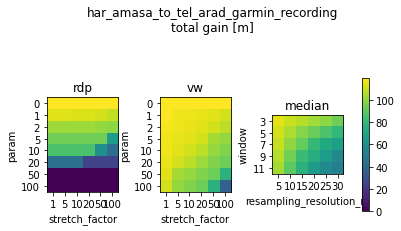

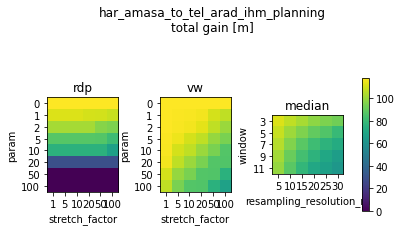

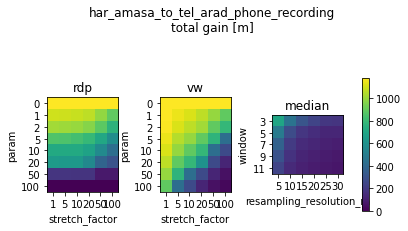

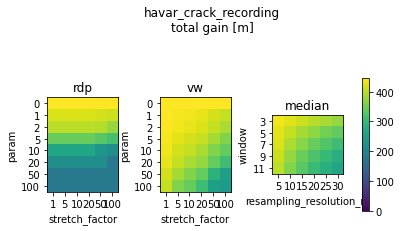

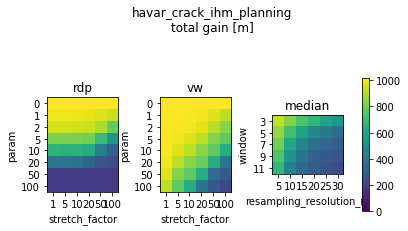

In [17]:
for name, route_data in all_routes_data.items():
    map_all_algos_data(route_data, name)

In [18]:
def plot_route(p, route_data, algo, param1, param2, color):
    simlified_data = route_data[algo][param1,param2]
    label = algo + ", " + str(param1) + ", " + str(param2) + ": " + str(round(simlified_data["gain_m"])) + "m/" + str(round(simlified_data["loss_m"])) + "m"
    p.line(simlified_data["simplified_route"]["cumdiff_m"], simlified_data["simplified_route"]["alt_m"], line_width=1, color=color, legend_label=label)

In [19]:
def draw_routes(all_routes_data, name):
    route_data = all_routes_data[name]
    p = figure(plot_width=450, plot_height=450, title=name)
    plot_route(p, route_data, "rdp", 1, 0, "blue")
    plot_route(p, route_data, "rdp", 10, 5, "grey")
    plot_route(p, route_data, "vw", 50, 20, "red")
    plot_route(p, route_data, "vw", 50, 50, "green")
    plot_route(p, route_data, "median", 15, 7, "cyan")
    plot_route(p, route_data, "median", 15, 11, "orange")
    plot_route(p, route_data, "median", 25, 11, "black")
    p.xaxis.axis_label = "distance along route [m]"
    p.yaxis.axis_label = "altitude [m]"
    p.legend.click_policy="hide"
    return p

In [20]:
for name in route_names:
    show(draw_routes(all_routes_data, name))